# Partie I - Collecte et traitement des données

1. Téléchargement des données

*1.1. Téléchargement des données à l'aide de l'API*

In [26]:
import requests
import pandas as pd
import os

# URL et clé API
url = "https://www.alphavantage.co/query"
api_key = "O0S7MV4XE2PDKBDF"

# Liste des symboles
symbols = {
    "apple": {"function": "TIME_SERIES_MONTHLY", "symbol": "AAPL"},
    "microsoft": {"function": "TIME_SERIES_MONTHLY", "symbol": "MSFT"},
    "google": {"function": "TIME_SERIES_MONTHLY", "symbol": "GOOGL"},
    "amazon": {"function": "TIME_SERIES_MONTHLY", "symbol": "AMZN"},
    "meta": {"function": "TIME_SERIES_MONTHLY", "symbol": "META"}
}

# Fonction pour télécharger les données
def download_data(asset_name, params):
    params["apikey"] = api_key
    params["datatype"] = "csv"
    response = requests.get(url, params=params)

    if response.status_code == 200:
        filename = f"{asset_name}_data.csv"
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Les données de {asset_name} ont été sauvegardées dans {filename}.")
    else:
        print(f"Erreur pour {asset_name}: {response.status_code}, {response.text}")

# Télécharger les données historiques
for asset, params in symbols.items():
    download_data(asset, params)

Les données de apple ont été sauvegardées dans apple_data.csv.
Les données de microsoft ont été sauvegardées dans microsoft_data.csv.
Les données de google ont été sauvegardées dans google_data.csv.
Les données de amazon ont été sauvegardées dans amazon_data.csv.
Les données de meta ont été sauvegardées dans meta_data.csv.


*2.2. Téléchargement des données sur Yahoo Finance*

In [27]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [28]:
import yfinance as yf
import pandas as pd

# Liste des tickers
assets = {
    "Gold": "GC=F",        # Gold Futures
    "Bitcoin": "BTC-USD",  # Bitcoin en USD
    "Ethereum": "ETH-USD", # Ethereum en USD
    "S&P 500": "^GSPC"     # S&P 500 Index
}

# Définir la plage de dates
start_date = "2000-01-01"
end_date = "2024-12-01"

# Télécharger les données pour chaque actif
for asset_name, ticker in assets.items():
    print(f"Téléchargement des données pour {asset_name} ({ticker})...")
    
    # Télécharger les données avec yfinance
    data = yf.download(ticker, start=start_date, end=end_date, interval="1mo")
    
    # Sauvegarder dans un fichier CSV
    filename = f"{asset_name.lower()}_historical_data.csv"
    data.to_csv(filename)
    print(f"Données sauvegardées dans {filename}.")

    # Afficher les premières lignes
    print(data.head())


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Téléchargement des données pour Gold (GC=F)...
Données sauvegardées dans gold_historical_data.csv.
Price            Close        High         Low        Open Volume
Ticker            GC=F        GC=F        GC=F        GC=F   GC=F
Date                                                             
2000-09-01  273.600006  278.399994  269.000000  277.000000   4291
2000-11-01  270.100006  270.200012  263.899994  263.899994  32465
2000-12-01  272.000000  276.000000  268.000000  269.700012   1664
2001-01-01  265.600006  268.399994  262.799988  268.399994  17811
2001-02-01  266.799988  268.899994  255.000000  266.299988   1066
Téléchargement des données pour Bitcoin (BTC-USD)...
Données sauvegardées dans bitcoin_historical_data.csv.
Price            Close        High         Low        Open      Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD     BTC-USD
Date                                                                  
2014-10-01  338.321014  411.697998  289.295990  387.

3. Création et nettoyage de la base de données 

*3.1. Création de la base de données à l'aide des fichiers téléchargés* 

In [29]:
# Liste des fichiers CSV avec leurs noms explicites (uniquement pour les entreprises)
companies = [
    "amazon_data.csv",
    "apple_data.csv",
    "google_data.csv",
    "meta_data.csv",
    "microsoft_data.csv"
]

# Créer un DataFrame principal avec toutes les dates possibles de 2000 à 2024
date_range = pd.date_range(start="2000-01", end="2024-12", freq="M")
final_df = pd.DataFrame({'year_month': date_range.to_period('M')})

# Boucle sur chaque fichier CSV
for file in companies:
    # Charger les données
    df = pd.read_csv(file)

    # Récupérer le nom de la société (extrait du nom de fichier)
    company_name = file.replace("_data.csv", "").replace(".csv", "").replace(" ", "")

    # Convertir la colonne timestamp en datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ajouter une colonne année-mois
    df['year_month'] = df['timestamp'].dt.to_period('M')

    # Calculer le prix moyen et garder les colonnes nécessaires
    df = df[['year_month', 'high', 'low', 'volume']]
    df[f'{company_name}_stock_price'] = (df['high'] + df['low']) / 2
    df[f'{company_name}_stock_volume'] = df['volume']

    # Garder uniquement les colonnes de la société traitée
    df = df[['year_month', f'{company_name}_stock_price', f'{company_name}_stock_volume']]

    # Supprimer les colonnes existantes dans final_df avant fusion
    for col in [f'{company_name}_stock_price', f'{company_name}_stock_volume']:
        if col in final_df.columns:
            final_df.drop(columns=col, inplace=True)

    # Fusionner directement avec le DataFrame principal
    final_df = pd.merge(final_df, df, on='year_month', how='left')

/tmp/ipykernel_108989/1212085898.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start="2000-01", end="2024-12", freq="M")


In [30]:
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume
0,2000-01,74.970,262209000,104.000,112099800,NaN,NaN,NaN,NaN,106.745,637437600
1,2000-02,74.500,207457700,108.470,65355200,NaN,NaN,NaN,NaN,99.060,667243800
2,2000-03,67.625,156584600,132.190,77663900,NaN,NaN,NaN,NaN,101.970,1014093800
3,2000-04,54.720,162012500,122.185,77342900,NaN,NaN,NaN,NaN,80.750,1129073300
4,2000-05,51.410,130688600,104.000,87569200,NaN,NaN,NaN,NaN,67.190,672215400


*3.2. Réorganisation de la base de données initiale*

In [31]:
element_files = [
    "bitcoin_historical_data.csv",
    "ethereum_historical_data.csv",
    "gold_historical_data.csv",
    "s&p 500_historical_data.csv"
]
# Boucle sur chaque fichier d'éléments
for file in element_files:
    # Charger les données en ignorant les deux premières lignes inutiles
    df = pd.read_csv(file, skiprows=2)

    # Récupérer le nom de l'élément
    element_name = file.replace("_historical_data.csv", "").replace(".csv", "").replace(" ", "").lower()

    # Renommer les colonnes en utilisant leur position
    df = df.iloc[:, [0, 2, 3, 5]]  # Sélectionne les colonnes Date, High, Low, Volume
    df.columns = ["timestamp", "high", "low", "volume"]  # Renommer pour uniformité

    # Convertir la colonne timestamp en datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ajouter une colonne année-mois
    df['year_month'] = df['timestamp'].dt.to_period('M')

    # Calculer le prix moyen
    df[f'{element_name}_price'] = (df['high'] + df['low']) / 2
    df[f'{element_name}_volume'] = df['volume']

    # Garder uniquement les colonnes nécessaires
    df = df[['year_month', f'{element_name}_price', f'{element_name}_volume']]

    # Supprimer les colonnes existantes avant fusion
    for col in [f'{element_name}_price', f'{element_name}_volume']:
        if col in final_df.columns:
            final_df.drop(columns=col, inplace=True)

    # Fusionner avec le DataFrame principal
    final_df = pd.merge(final_df, df, on='year_month', how='left')


In [32]:
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
0,2000-01,74.970,262209000,104.000,112099800,NaN,NaN,NaN,NaN,106.745,637437600,NaN,NaN,NaN,NaN,NaN,NaN,1414.070007,21494400000
1,2000-02,74.500,207457700,108.470,65355200,NaN,NaN,NaN,NaN,99.060,667243800,NaN,NaN,NaN,NaN,NaN,NaN,1384.809998,20912000000
2,2000-03,67.625,156584600,132.190,77663900,NaN,NaN,NaN,NaN,101.970,1014093800,NaN,NaN,NaN,NaN,NaN,NaN,1449.744995,26156200000
3,2000-04,54.720,162012500,122.185,77342900,NaN,NaN,NaN,NaN,80.750,1129073300,NaN,NaN,NaN,NaN,NaN,NaN,1433.294983,20106460000
4,2000-05,51.410,130688600,104.000,87569200,NaN,NaN,NaN,NaN,67.190,672215400,NaN,NaN,NaN,NaN,NaN,NaN,1421.299988,19898300000


In [33]:
print(len(final_df))

299


*3.3. Traitement des valeurs manquantes*

In [34]:
# Compter le nombre total de valeurs manquantes dans final_df
missing_values_count = final_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes dans final_df : {missing_values_count}")


Nombre total de valeurs manquantes dans final_df : 1294


VM où il y a au moins une valeur dans une année

In [35]:
# Vérifier les colonnes avec des valeurs numériques uniquement
numeric_columns = final_df.select_dtypes(include=['float64', 'int64']).columns

# Remplacer les valeurs manquantes par la moyenne annuelle si possible
for col in numeric_columns:
    # Calculer la moyenne annuelle pour chaque colonne (en ignorant les NaN)
    annual_mean = final_df.groupby(final_df['year_month'].dt.year)[col].transform('mean')
    
    # Remplacer les NaN par la moyenne annuelle calculée
    final_df[col] = final_df[col].fillna(annual_mean)


In [36]:
missing_values_count = final_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes dans final_df : {missing_values_count}")

Nombre total de valeurs manquantes dans final_df : 1128


VM qui restent

In [37]:
for col in numeric_columns:
    # Calculer la moyenne globale (en ignorant les NaN)
    global_mean = final_df[col].mean()
    
    # Remplacer les NaN restants par la moyenne globale
    final_df[col] = final_df[col].fillna(global_mean)

In [38]:
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
0,2000-01,74.970,262209000,104.000,112099800,760.629032,1.979314e+08,177.585127,6.236496e+08,106.745,637437600,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1414.070007,21494400000
1,2000-02,74.500,207457700,108.470,65355200,760.629032,1.979314e+08,177.585127,6.236496e+08,99.060,667243800,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1384.809998,20912000000
2,2000-03,67.625,156584600,132.190,77663900,760.629032,1.979314e+08,177.585127,6.236496e+08,101.970,1014093800,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1449.744995,26156200000
3,2000-04,54.720,162012500,122.185,77342900,760.629032,1.979314e+08,177.585127,6.236496e+08,80.750,1129073300,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1433.294983,20106460000
4,2000-05,51.410,130688600,104.000,87569200,760.629032,1.979314e+08,177.585127,6.236496e+08,67.190,672215400,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1421.299988,19898300000


In [39]:
missing_values_count = final_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes dans final_df : {missing_values_count}")

Nombre total de valeurs manquantes dans final_df : 0


# Partie II - Partie descriptive

Cette partie a pour objectif de décrire et interpréter les fluctuations de l'or et des principales cryptomonnaies et actions sur les marchés financiers. 
Cette première analyse met en évidence ce que l'on cherchera à expliquer dans la partie suivante. 

1. Travail préliminaire d'aide à la visualisation

*1.1. Affichage des données*

Afin de faciliter la visualisation, on conserve trois décimales pour le prix des actions pour lesquelles ce n'est pas déjà le cas. On conserve six décimales pour le prix des cryptomonnaies. En effet, les cryptomonnaies sont divisibles en très petites unités ; réduire le nombre de décimales serait donc synonyme de perte d'information.

In [40]:
# Arrondir le prix des actions à 3 décimales lorsque nécessaire 
final_df = final_df.round({'amazon_stock_price': 3, 'google_stock_price': 3, 'meta_stock_price': 3})


On effectue également des modifications sur le volume en évitant l'écriture scientifique pour plus de lisibilité. 

In [41]:
# Fonction pour convertir les colonnes spécifiées en entiers
def convert_to_int(df, columns):
    df[columns] = df[columns].astype(int)
    return df

In [42]:
# On utilise alors la fonction avec la liste des colonnes à convertir suivante:
columns_converted = ['google_stock_volume', 'ethereum_volume', 'bitcoin_volume', 's&p500_volume', 'meta_stock_volume']

# Application de la fonction à final_df
final_df = convert_to_int(final_df, columns_converted)

# Afficher les premières lignes du df modifié 
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
0,2000-01,74.970,262209000,104.000,112099800,760.629,197931417,177.585,623649587,106.745,637437600,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1414.070007,21494400000
1,2000-02,74.500,207457700,108.470,65355200,760.629,197931417,177.585,623649587,99.060,667243800,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1384.809998,20912000000
2,2000-03,67.625,156584600,132.190,77663900,760.629,197931417,177.585,623649587,101.970,1014093800,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1449.744995,26156200000
3,2000-04,54.720,162012500,122.185,77342900,760.629,197931417,177.585,623649587,80.750,1129073300,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1433.294983,20106460000
4,2000-05,51.410,130688600,104.000,87569200,760.629,197931417,177.585,623649587,67.190,672215400,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1421.299988,19898300000


*1.2. Premières statistiques descriptives*


On affiche dans un premier temps les statistiques descriptives pour l'ensemble des variables sur toute la période considérée. 

In [43]:
final_df.describe()

,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
count,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,299.000000,299.000000,2.990000e+02
mean,596.030870,2.338483e+08,174.491543,6.998301e+08,760.629023,1.979314e+08,177.585080,6.236496e+08,95.281551,9.467717e+08,17705.370867,5.175726e+11,1382.316098,3.549254e+11,1130.947491,86970.130202,2089.054264,7.019747e+10
std,926.010738,3.250052e+08,146.158314,5.723511e+08,556.747755,1.904352e+08,90.532894,2.539357e+08,106.370793,4.192055e+08,13593.217299,3.559801e+11,652.536490,1.561093e+11,583.686008,106398.638197,1218.513567,2.891918e+10
min,7.430000,4.346880e+07,13.835000,6.535520e+07,92.190000,2.304129e+07,20.240000,2.261357e+08,16.875000,3.423704e+08,238.188499,5.531023e+08,120.249294,4.445981e+10,261.949997,893.000000,749.884979,1.908910e+10
25%,46.572500,8.275704e+07,77.362500,2.987677e+08,453.977500,4.281145e+07,157.200000,5.049505e+08,27.612500,6.061426e+08,10764.107300,5.175726e+11,1382.316098,3.549254e+11,603.750000,9102.500000,1198.367462,4.829011e+10
50%,166.420000,1.333624e+08,140.775000,5.620912e+08,688.650000,1.458872e+08,177.585000,6.236496e+08,46.980000,8.593311e+08,17705.370867,5.175726e+11,1382.316098,3.549254e+11,1230.500000,19001.400000,1475.320007,7.561031e+10
75%,658.722500,1.916486e+08,204.112500,9.000309e+08,858.920000,2.303744e+08,177.585000,6.236496e+08,105.185000,1.272418e+09,17705.370867,5.175726e+11,1382.316098,3.549254e+11,1608.324982,157753.000000,2712.147522,8.618484e+10
max,3540.029000,2.035252e+09,680.535000,3.886793e+09,2925.680000,9.527097e+08,582.235000,2.032635e+09,440.280000,3.044579e+09,83229.574219,2.267153e+12,4412.605591,1.510330e+12,2695.750000,443701.000000,5870.339844,1.621854e+11


A noter que le premier mois pour lequel on a pu collecter les données sont:
- Pour Google: 2004-09
- Pour Meta: 2012-06
- Pour l'Ethereum: 2017-12
- Pour le Bitcoin: 2014-10
- Pour l'or: 2000-09

On effectue également l'analyse à partir du mois de décembre 2017 pour avoir les statistiques les plus récentes avec toutes les données disponibles.

In [44]:
# Filtrage des données postérieures à décembre 2017
latest_data = final_df[final_df['year_month'] >= '2017-12']

# Statistiques descriptives sur les données les plus récentes 
latest_data.describe()

,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
count,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,84.00000,84.000000,8.400000e+01
mean,1594.253667,4.697608e+08,187.072438,1.282012e+09,1145.468440,2.387685e+08,259.706262,4.777404e+08,238.366378,5.961304e+08,27046.966609,8.010751e+11,1478.453297,3.909455e+11,1745.663167,107779.49145,3791.361604,8.687678e+10
std,1228.862564,5.396450e+08,52.987103,6.516978e+08,885.194366,2.874301e+08,112.895236,1.914812e+08,104.984100,1.768703e+08,20394.128314,4.773935e+11,1203.331925,2.759660e+11,348.589170,118724.77008,892.269236,1.591233e+10
min,89.460000,5.206047e+07,114.655000,3.938439e+08,92.190000,2.304129e+07,103.415000,2.261357e+08,84.099950,3.423704e+08,3750.340454,1.184369e+11,120.249294,4.445981e+10,1192.549988,4126.00000,2573.380005,6.303151e+10
25%,175.215000,7.801962e+07,149.620000,7.381035e+08,160.786750,3.362435e+07,179.716250,3.341730e+08,138.373750,4.801091e+08,9139.994873,4.686604e+11,278.960136,1.999103e+11,1403.262502,9281.75000,2913.869934,7.762015e+10
50%,1723.557500,1.144326e+08,174.112500,1.185673e+09,1167.820000,4.132788e+07,216.230000,4.400423e+08,236.045000,5.624099e+08,22068.976562,7.729387e+11,1430.734009,3.697663e+11,1793.075043,35064.50000,3874.002502,8.243948e+10
75%,2930.565000,9.361697e+08,207.103750,1.684877e+09,1559.839000,5.371061e+08,316.000750,5.534249e+08,310.186250,6.690356e+08,42547.661621,1.051473e+12,2369.349976,5.218055e+11,1935.687500,196233.00000,4393.913879,9.240001e+10
max,3540.029000,2.035252e+09,391.120000,3.886793e+09,2925.680000,9.527097e+08,582.235000,1.127891e+09,440.280000,1.612954e+09,83229.574219,2.267153e+12,4412.605591,1.510330e+12,2695.750000,443701.00000,5870.339844,1.621854e+11


On remarque que les actions Amazon, Google et Meta, Microsoft ainsi que le Bitcoin et l'or ont connu leur maximum historique entre fin 2017 et 2024. Google a également atteint son prix minimal pendant la période la plus récente. Pour toutes les autres actions et pour l'or et les cryptomonnaies créées avant 2017, le prix minimum a été atteint avant décembre 2017. On observe donc une tendance de décalage vers le haut du prix minimal. Pour le Bitcoin, on remarque que le prix minimal sur la période récente ($20394.128314) est bien supérieur à celui sur la période antérieure à décembre 2017 ($238.188499), ce qui montre l'attrait croissant pour la détention pour le Bitcoin au fil des années. 

*1.3. Premières représentations graphiques*

In [ ]:
# Import de Matplotlib - à mettre au tout début du projet avec tous les imports? + réfléchir à faire une fonction qui trace les graphiques pour alléger le code 
import matplotlib.pyplot as plt

On représente dans un premier temps le prix des différentes cryptomonnaies et de l'or depuis décembre 2017.

In [46]:
# Convertir year_month en timestamp
latest_data['year_month'] = latest_data['year_month'].dt.to_timestamp()

/tmp/ipykernel_108989/2846099359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['year_month'] = latest_data['year_month'].dt.to_timestamp()


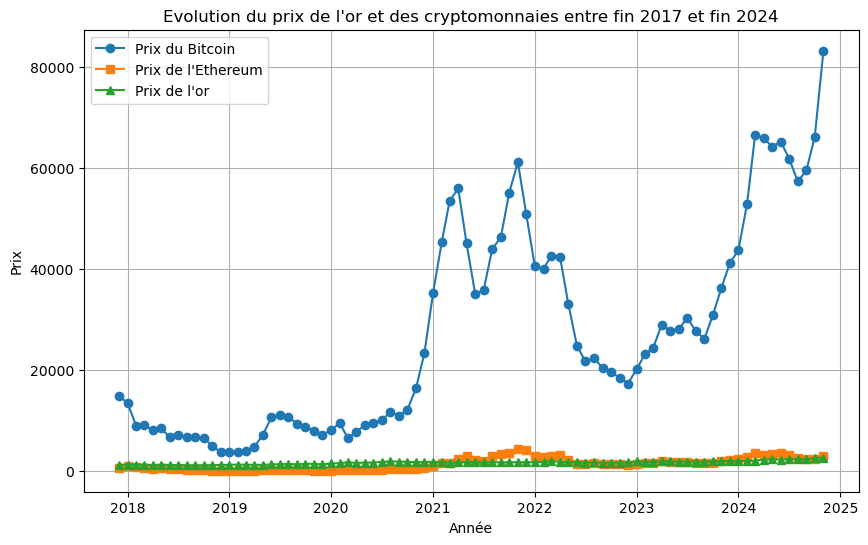

In [47]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour les 3 variables
plt.plot(latest_data['year_month'], latest_data['bitcoin_price'], label='Prix du Bitcoin', marker='o')  # Courbe pour le Bitcoin
plt.plot(latest_data['year_month'], latest_data['ethereum_price'], label="Prix de l'Ethereum", marker='s')  # Courbe pour l'Ethereum
plt.plot(latest_data['year_month'], latest_data['gold_price'], label="Prix de l'or", marker='^')  # Courbe pour l'or

plt.title("Evolution du prix de l'or et des cryptomonnaies entre fin 2017 et fin 2024")
plt.xlabel('Année')  # Modifier en fonction de l'axe x, par exemple une colonne 'Date'
plt.ylabel('Prix')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

Dans un objectif de lisibilité, on trace un graphique avec seulement l'or et l'Ethereum pour mieux rendre compte graphiquement des variations du prix.

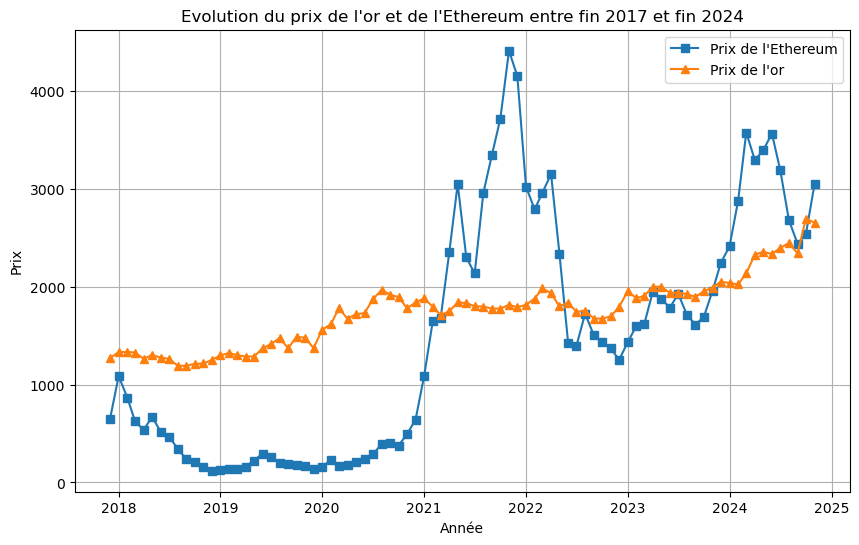

In [54]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour les 2 variables
plt.plot(latest_data['year_month'], latest_data['ethereum_price'], label="Prix de l'Ethereum", marker='s')  # Courbe pour l'Ethereum
plt.plot(latest_data['year_month'], latest_data['gold_price'], label="Prix de l'or", marker='^')  # Courbe pour l'or

plt.title("Evolution du prix de l'or et de l'Ethereum entre fin 2017 et fin 2024")
plt.xlabel('Année')  
plt.ylabel('Prix')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

On représente également le prix des actions ainsi que le volume entre 2000 et aujourd'hui. !!! Séparer volumes et prix car on observe que les volumes sont bien plus importants donc problème de représentation graphique.

In [49]:
# On effectue la même modification sur les dates sur final_df pour pouvoir effectuer la représentation graphique
final_df['year_month'] = final_df['year_month'].dt.to_timestamp()

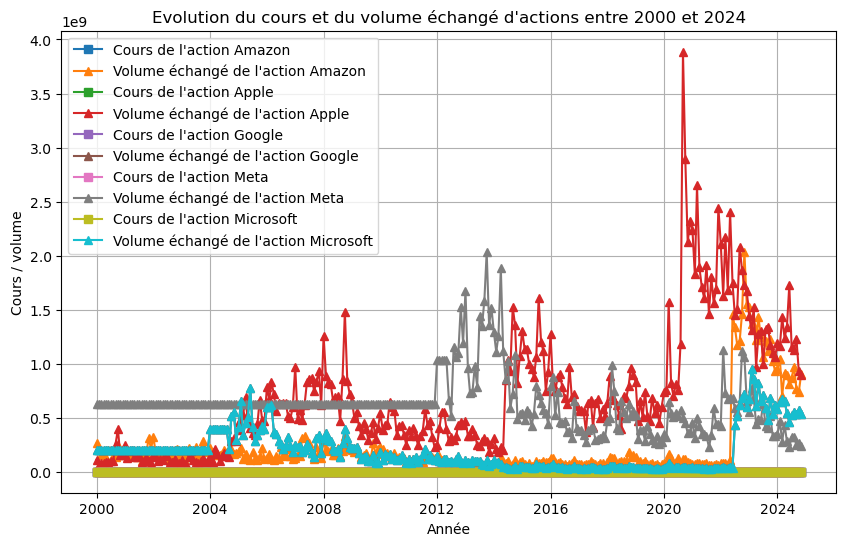

In [ ]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour les variables
plt.plot(final_df['year_month'], final_df['amazon_stock_price'], label="Cours de l'action Amazon", marker='s')  
plt.plot(final_df['year_month'], final_df['amazon_stock_volume'], label="Volume échangé de l'action Amazon", marker='^')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['apple_stock_price'], label="Cours de l'action Apple", marker='s')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['apple_stock_volume'], label="Volume échangé de l'action Apple", marker='^')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['google_stock_price'], label="Cours de l'action Google", marker='s')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['google_stock_volume'], label="Volume échangé de l'action Google", marker='^')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['meta_stock_price'], label="Cours de l'action Meta", marker='s')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['meta_stock_volume'], label="Volume échangé de l'action Meta", marker='^')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['google_stock_price'], label="Cours de l'action Microsoft", marker='s')  # Courbe pour l'or
plt.plot(final_df['year_month'], final_df['google_stock_volume'], label="Volume échangé de l'action Microsoft", marker='^')  # Courbe pour l'or

plt.title("Evolution du cours et du volume échangé d'actions entre 2000 et 2024")
plt.xlabel('Année')  
plt.ylabel('Cours / volume')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

On effectue le même graphique sur la période la plus récente pour mieux rendre compte des variations. 

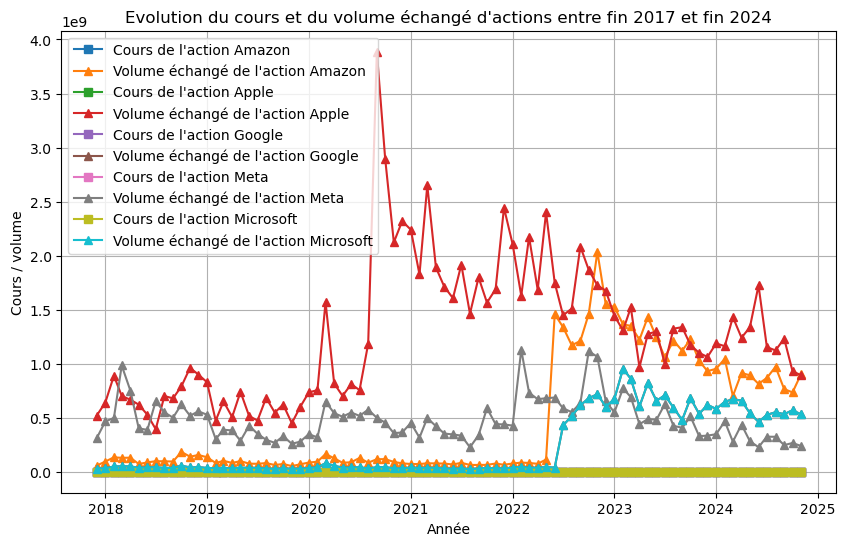

In [57]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour les variables
plt.plot(latest_data['year_month'], latest_data['amazon_stock_price'], label="Cours de l'action Amazon", marker='s')  
plt.plot(latest_data['year_month'], latest_data['amazon_stock_volume'], label="Volume échangé de l'action Amazon", marker='^')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['apple_stock_price'], label="Cours de l'action Apple", marker='s')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['apple_stock_volume'], label="Volume échangé de l'action Apple", marker='^')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['google_stock_price'], label="Cours de l'action Google", marker='s')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['google_stock_volume'], label="Volume échangé de l'action Google", marker='^')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['meta_stock_price'], label="Cours de l'action Meta", marker='s')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['meta_stock_volume'], label="Volume échangé de l'action Meta", marker='^')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['google_stock_price'], label="Cours de l'action Microsoft", marker='s')  # Courbe pour l'or
plt.plot(latest_data['year_month'], latest_data['google_stock_volume'], label="Volume échangé de l'action Microsoft", marker='^')  # Courbe pour l'or

plt.title("Evolution du cours et du volume échangé d'actions entre fin 2017 et fin 2024")
plt.xlabel('Année') 
plt.ylabel('Cours / volume')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

On représente également l'évolution pour le S&P 500 sur toute la période et sur la période la plus récente. 

Sur toute la période, on obtient les graphiques suivants. 

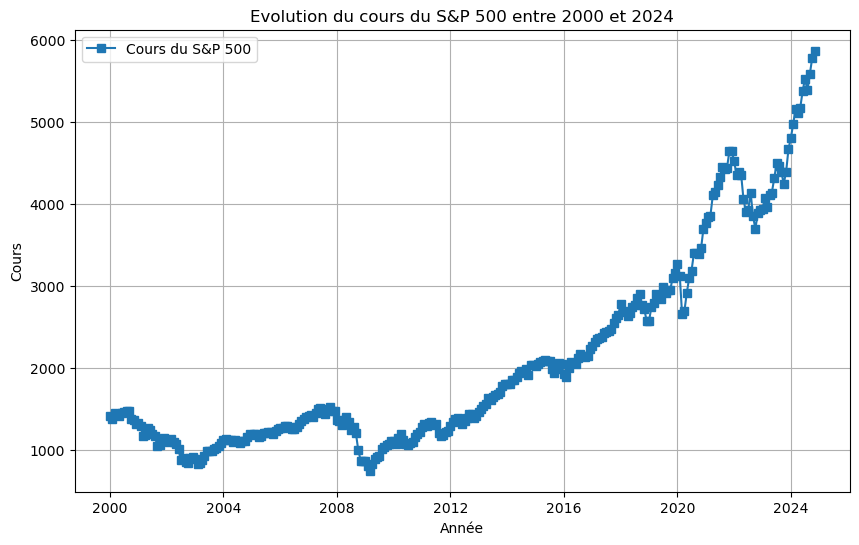

In [ ]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour la variable
plt.plot(final_df['year_month'], final_df['s&p500_price'], label="Cours du S&P 500", marker='s')  


plt.title("Evolution du cours du S&P 500 entre 2000 et 2024")
plt.xlabel('Année')  
plt.ylabel('Cours')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

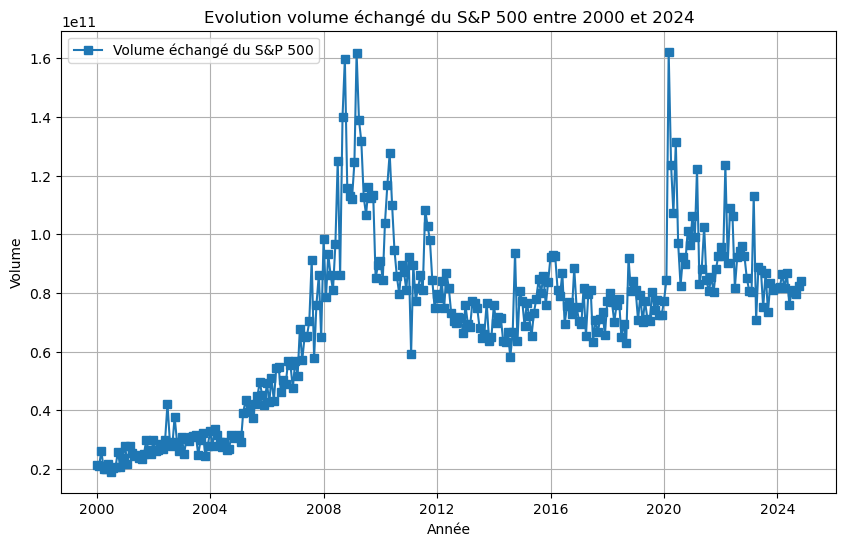

In [ ]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour la variable
plt.plot(final_df['year_month'], final_df['s&p500_volume'], label="Volume échangé du S&P 500", marker='s')  


plt.title("Evolution volume échangé du S&P 500 entre 2000 et 2024")
plt.xlabel('Année')  
plt.ylabel('Volume')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

Sur la période la plus récente, on obtient les graphiques suivants.

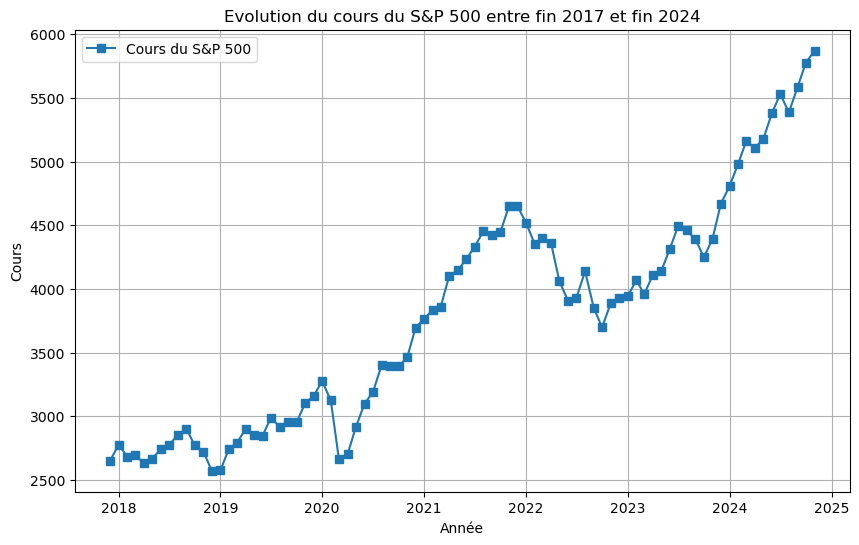

In [ ]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour la variable
plt.plot(latest_data['year_month'], latest_data['s&p500_price'], label="Cours du S&P 500", marker='s')  


plt.title("Evolution du cours du S&P 500 entre fin 2017 et fin 2024")
plt.xlabel('Année')  
plt.ylabel('Cours')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

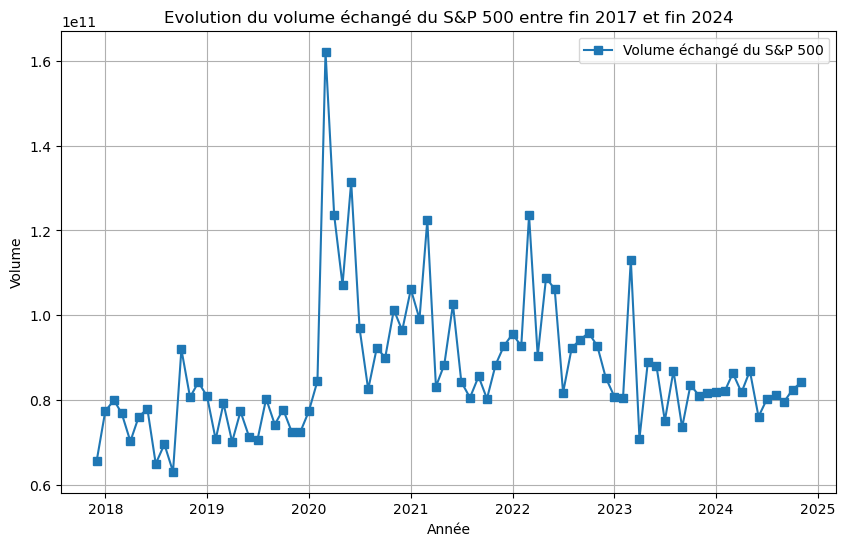

In [69]:
plt.figure(figsize=(10, 6))


# Tracer les courbes pour la variable
plt.plot(latest_data['year_month'], latest_data['s&p500_volume'], label="Volume échangé du S&P 500", marker='s')  


plt.title("Evolution du volume échangé du S&P 500 entre fin 2017 et fin 2024")
plt.xlabel('Année')  
plt.ylabel('Volume')
plt.legend()  # Afficher la légende
plt.grid(True)  # Afficher une grille

# Afficher le graphique
plt.show()

# Partie III- Modélisation

In [96]:
# Calculer le maximum des 6 derniers mois
final_df['6_months_max'] = final_df['s&p500_price'].rolling(window=6, min_periods=6).max()

# Calculer la variation en pourcentage par rapport au maximum des 6 derniers mois
final_df['percent_change'] = (final_df['s&p500_price'] - final_df['6_months_max']) / final_df['6_months_max'] * 100

# Détecter les crises avec un seuil de -10 %
final_df['crisis'] = final_df['percent_change'].apply(lambda x: 1 if x <= -10 else (0 if pd.notna(x) else pd.NA))

# Afficher uniquement les lignes où une crise est détectée
crisis_df = final_df[final_df['crisis'] == 1]
print(crisis_df[['year_month', 's&p500_price', '6_months_max', 'percent_change', 'crisis']])

    year_month  s&p500_price  6_months_max  percent_change crisis
11     2000-12   1321.559998   1475.320007      -10.422146      1
13     2001-02   1295.909973   1474.764954      -12.127694      1
14     2001-03   1174.304993   1380.304993      -14.924238      1
15     2001-04   1180.645020   1366.679993      -13.612182      1
20     2001-09   1050.075012   1273.965027      -17.574267      1
21     2001-10   1068.684998   1273.965027      -16.113474      1
22     2001-11   1108.845032   1244.825012      -10.923622      1
29     2002-06   1011.829987   1140.334961      -11.269055      1
30     2002-07    885.070007   1140.334961      -22.385085      1
31     2002-08    899.220001   1140.334961      -21.144222      1
32     2002-09    862.110016   1105.649963      -22.026858      1
33     2002-10    838.035004   1077.774963      -22.243972      1
34     2002-11    906.934998   1011.829987      -10.366859      1
96     2008-01   1370.910034   1532.825012      -10.563174      1
97     200

In [97]:
filtered_2020_crisis = final_df[(final_df['crisis'] == 1) & (final_df['year_month'].astype(str).str.startswith('2020'))]

# Afficher uniquement les colonnes 'year_month' et 'crisis'
print(filtered_2020_crisis[['year_month', 'crisis']])

    year_month crisis
242    2020-03      1
243    2020-04      1
244    2020-05      1


In [98]:
!pip install arch

In [99]:
import numpy as np
from arch import arch_model

In [104]:
# Calcul des rendements logarithmiques pour l'or
final_df['gold_return'] = np.log(final_df['gold_price'] / final_df['gold_price'].shift(1))

# Calcul des rendements logarithmiques pour Amazon
final_df['stock_return'] = np.log(final_df['amazon_stock_price'] / final_df['amazon_stock_price'].shift(1))

# Supprimer les lignes avec des valeurs manquantes (les premières lignes créées par shift)
final_df = final_df.dropna()

# Afficher les premières lignes pour vérifier
print(final_df[['gold_return', 'stock_return']].head())

   gold_return  stock_return
5     0.000000     -0.126526
6     0.000000     -0.232291
7     0.000000      0.020125
8     0.010221      0.149892
9    -0.010221     -0.386845


In [105]:
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.optimize import minimize
from statsmodels.api import OLS, add_constant

In [107]:
# 1. Préparer les données
final_df = final_df[(final_df['gold_price'] > 0) & (final_df['amazon_stock_price'] > 0)]
final_df = final_df.dropna()

# Calculer les rendements logarithmiques
final_df['gold_return'] = np.log(final_df['gold_price'] / final_df['gold_price'].shift(1)) * 100
final_df['amazon_stock_return'] = np.log(final_df['amazon_stock_price'] / final_df['amazon_stock_price'].shift(1)) * 100
final_df = final_df.dropna()

# 2. Ajuster les modèles GARCH univariés
gold_model = arch_model(final_df['gold_return'], mean='Zero', vol='Garch', p=1, q=1)
gold_fit = gold_model.fit(disp="off")

amazon_model = arch_model(final_df['amazon_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
amazon_fit = amazon_model.fit(disp="off")
# Extraire les résidus standardisés
gold_std_resid = gold_fit.std_resid
amazon_std_resid = amazon_fit.std_resid

# Variables muettes basées sur les résidus standardisés
final_df['dum_gold_neg'] = (gold_std_resid < 0).astype(int)
final_df['dum_stock_neg'] = (amazon_std_resid < 0).astype(int)
final_df['interaction'] = final_df['dum_gold_neg'] * final_df['dum_stock_neg']

In [108]:
# 3. Calcul de la covariance conditionnelle
final_df['covariance_conditionnelle'] = gold_std_resid * amazon_std_resid

# 4. Ajouter la variable de crise
final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)  # Variable de crise (assurez-vous que 'crisis' existe)

# 5. Régression pour estimer c_GS et delta_GS
X = final_df[['gold_return', 'amazon_stock_return', 'interaction', 'dum_crise']]
X = add_constant(X)  # Ajouter une constante pour inclure c_GS
y = final_df['covariance_conditionnelle']

model_hGS = OLS(y, X)
results_hGS = model_hGS.fit()

# 6. Résultats de la régression
print("\nRésultats de la régression pour h_GS :")
print(results_hGS.summary())


Résultats de la régression pour h_GS :
                                OLS Regression Results                               
Dep. Variable:     covariance_conditionnelle   R-squared:                       0.121
Model:                                   OLS   Adj. R-squared:                  0.109
Method:                        Least Squares   F-statistic:                     9.918
Date:                       Tue, 24 Dec 2024   Prob (F-statistic):           1.57e-07
Time:                               11:08:39   Log-Likelihood:                -408.77
No. Observations:                        293   AIC:                             827.5
Df Residuals:                            288   BIC:                             845.9
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

In [109]:
# Extraire les coefficients
c_GS = results_hGS.params['const']
delta_GS = results_hGS.params['dum_crise']
cGS_sum = c_GS + delta_GS
cGS_sum

np.float64(-0.21330410455353124)

In [110]:
def analyze_company(company_name):
    """
    Applique un modèle ARMA-GARCH univarié et effectue une régression pour estimer c_GS et delta_GS pour une entreprise donnée.

    Arguments :
    - company_name : Nom de l'entreprise (utilisé pour les colonnes, par exemple 'amazon').

    Retourne :
    - Un dictionnaire contenant c_GS, delta_GS et leur somme.
    """
    # Charger les données globales
    global final_df

    # Vérifier que les colonnes nécessaires existent
    price_col = f"{company_name}_stock_price"
    if price_col not in final_df.columns:
        raise ValueError(f"La colonne {price_col} est absente du DataFrame.")

    # Préparer les données
    final_df = final_df[(final_df['gold_price'] > 0) & (final_df[price_col] > 0)]
    final_df = final_df.dropna()

    # Calculer les rendements logarithmiques
    final_df['gold_return'] = np.log(final_df['gold_price'] / final_df['gold_price'].shift(1)) * 100
    final_df[f'{company_name}_stock_return'] = np.log(final_df[price_col] / final_df[price_col].shift(1)) * 100
    final_df = final_df.dropna()

    # Ajuster les modèles GARCH univariés
    gold_model = arch_model(final_df['gold_return'], mean='Zero', vol='Garch', p=1, q=1)
    gold_fit = gold_model.fit(disp="off")

    company_model = arch_model(final_df[f'{company_name}_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
    company_fit = company_model.fit(disp="off")

    # Extraire les résidus standardisés
    gold_std_resid = gold_fit.std_resid
    company_std_resid = company_fit.std_resid

    # Variables muettes basées sur les résidus standardisés
    final_df['dum_gold_neg'] = (gold_std_resid < 0).astype(int)
    final_df['dum_stock_neg'] = (company_std_resid < 0).astype(int)
    final_df['interaction'] = final_df['dum_gold_neg'] * final_df['dum_stock_neg']

    # Calcul de la covariance conditionnelle
    final_df['covariance_conditionnelle'] = gold_std_resid * company_std_resid

    # Ajouter la variable de crise
    final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

    # Régression pour estimer c_GS et delta_GS
    X = final_df[['gold_return', f'{company_name}_stock_return', 'interaction', 'dum_crise']]
    X = add_constant(X)  # Ajouter une constante pour inclure c_GS
    y = final_df['covariance_conditionnelle']

    model_hGS = OLS(y, X)
    results_hGS = model_hGS.fit()

    # Extraire les coefficients
    c_GS = results_hGS.params['const']
    delta_GS = results_hGS.params['dum_crise']

    return {
        'company': company_name,
        'cGS_sum': c_GS + delta_GS
    }

In [120]:
companies = ['amazon', 'meta', 'apple', 'google', 'microsoft']
results = []

for company in companies:
    try:
        result = analyze_company(company)
        results.append(result)
    except ValueError as e:
        print(f"Erreur pour {company} : {e}")

# Afficher les résultats
for res in results:
    print(res)


{'company': 'amazon', 'cGS_sum': np.float64(-0.12931772447927903)}
{'company': 'meta', 'cGS_sum': np.float64(-0.05047898131401185)}
{'company': 'apple', 'cGS_sum': np.float64(-0.4345841224632422)}
{'company': 'google', 'cGS_sum': np.float64(-0.025545394908827464)}
{'company': 'microsoft', 'cGS_sum': np.float64(-0.4595552070896764)}


In [112]:
def calculate_return_asset(asset):
    """
    Calcule les rendements logarithmiques pour un actif spécifique et les ajoute au DataFrame global.

    Arguments :
    - asset 

    Retourne :
    - Le DataFrame mis à jour avec la colonne de rendements ajoutée pour l'actif spécifié.
    """
    global final_df

    price_col = f"{asset}_price"
    return_col = f"{asset}_return"
    if price_col in final_df.columns:
        final_df[return_col] = np.log(final_df[price_col] / final_df[price_col].shift(1))
    else:
        print(f"La colonne {price_col} est absente du DataFrame. Skipping {x}.")

    final_df = final_df.dropna()
    return final_df


In [113]:
def calculate_return_company(company):
    """
    Calcule les rendements logarithmiques pour un actif spécifique et les ajoute au DataFrame global.

    Arguments :
    - company 

    Retourne :
    - Le DataFrame mis à jour avec la colonne de rendements ajoutée pour l'actif spécifié.
    """
    global final_df

    price_col = f"{company}_stock_price"
    return_col = f"{company}_return"
    if price_col in final_df.columns:
        final_df[return_col] = np.log(final_df[price_col] / final_df[price_col].shift(1))
    else:
        print(f"La colonne {price_col} est absente du DataFrame. Skipping {x}.")

    final_df = final_df.dropna()
    return final_df


In [119]:
assets = ['gold', 'bitcoin', 'ethereum']

In [115]:
for asset in assets:
    calculate_return_assset(asset)
for company in companies: 
    calculate_return_company(company)


In [117]:
def analyze_company_bitcoin(company_name):
    """
    Applique un modèle ARMA-GARCH univarié et effectue une régression pour estimer c_GS et delta_GS pour une entreprise donnée.

    Arguments :
    - company_name : Nom de l'entreprise (utilisé pour les colonnes, par exemple 'amazon').

    Retourne :
    - Un dictionnaire contenant c_GS, delta_GS et leur somme.
    """
    # Charger les données globales
    global final_df

    # Vérifier que les colonnes nécessaires existent
    price_col = f"{company_name}_stock_price"
    if price_col not in final_df.columns:
        raise ValueError(f"La colonne {price_col} est absente du DataFrame.")

    # Préparer les données
    final_df = final_df[(final_df['bitcoin_price'] > 0) & (final_df[price_col] > 0)]
    final_df = final_df.dropna()

    # Calculer les rendements logarithmiques
    final_df['bitcoin_return'] = np.log(final_df['bitcoin_price'] / final_df['bitcoin_price'].shift(1)) * 100
    final_df[f'{company_name}_stock_return'] = np.log(final_df[price_col] / final_df[price_col].shift(1)) * 100
    final_df = final_df.dropna()

    # Ajuster les modèles GARCH univariés
    gold_model = arch_model(final_df['bitcoin_return'], mean='Zero', vol='Garch', p=1, q=1)
    gold_fit = gold_model.fit(disp="off")

    company_model = arch_model(final_df[f'{company_name}_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
    company_fit = company_model.fit(disp="off")

    # Extraire les résidus standardisés
    gold_std_resid = gold_fit.std_resid
    company_std_resid = company_fit.std_resid

    # Variables muettes basées sur les résidus standardisés
    final_df['dum_bitcoin_neg'] = (gold_std_resid < 0).astype(int)
    final_df['dum_stock_neg'] = (company_std_resid < 0).astype(int)
    final_df['interaction'] = final_df['dum_bitcoin_neg'] * final_df['dum_bitcoin_neg']

    # Calcul de la covariance conditionnelle
    final_df['covariance_conditionnelle'] = gold_std_resid * company_std_resid

    # Ajouter la variable de crise
    final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

    # Régression pour estimer c_GS et delta_GS
    X = final_df[['bitcoin_return', f'{company_name}_stock_return', 'interaction', 'dum_crise']]
    X = add_constant(X)  # Ajouter une constante pour inclure c_GS
    y = final_df['covariance_conditionnelle']

    model_hGS = OLS(y, X)
    results_hGS = model_hGS.fit()

    # Extraire les coefficients
    c_GS = results_hGS.params['const']
    delta_GS = results_hGS.params['dum_crise']

    return {
        'company': company_name,
        'cGS_sum': c_GS + delta_GS
    }

Index(['year_month', 'amazon_stock_price', 'amazon_stock_volume',
       'apple_stock_price', 'apple_stock_volume', 'google_stock_price',
       'google_stock_volume', 'meta_stock_price', 'meta_stock_volume',
       'microsoft_stock_price', 'microsoft_stock_volume',
       'gold_historical_data_2000_2024_price',
       'gold_historical_data_2000_2024_volume', '6_months_max',
       'percent_change', 'crisis', 'gold_return', 'stock_return',
       'amazon_stock_return', 'dum_gold_neg', 'dum_stock_neg', 'interaction',
       'covariance_conditionnelle', 'dum_crise', 'meta_stock_return',
       'apple_stock_return', 'google_stock_return', 'microsoft_stock_return',
       'amazon_return', 'dum_asset_neg', 'dum_company_neg', 'meta_return',
       'apple_return', 'bitcoin_price', 'bitcoin_volume', 'ethereum_price',
       'ethereum_volume', 'gold_price', 'gold_volume', 's&p500_price',
       's&p500_volume', 'bitcoin_return', 'ethereum_return'],
      dtype='object')


In [122]:
results = []

for company in companies:
    try:
        result = analyze_company_bitcoin(company)
        results.append(result)
    except ValueError as e:
        print(f"Erreur pour {company} : {e}")

# Afficher les résultats
for res in results:
    print(res)


{'company': 'amazon', 'cGS_sum': np.float64(0.24384754434965755)}
{'company': 'meta', 'cGS_sum': np.float64(0.1223336476621433)}
{'company': 'apple', 'cGS_sum': np.float64(0.15964622915622878)}
{'company': 'google', 'cGS_sum': np.float64(0.1583833240792347)}
{'company': 'microsoft', 'cGS_sum': np.float64(0.29926955835675906)}


In [123]:
def analyze_company_ethereum(company_name):
    """
    Applique un modèle ARMA-GARCH univarié et effectue une régression pour estimer c_GS et delta_GS pour une entreprise donnée.

    Arguments :
    - company_name : Nom de l'entreprise (utilisé pour les colonnes, par exemple 'amazon').

    Retourne :
    - Un dictionnaire contenant c_GS, delta_GS et leur somme.
    """
    # Charger les données globales
    global final_df

    # Vérifier que les colonnes nécessaires existent
    price_col = f"{company_name}_stock_price"
    if price_col not in final_df.columns:
        raise ValueError(f"La colonne {price_col} est absente du DataFrame.")

    # Préparer les données
    final_df = final_df[(final_df['ethereum_price'] > 0) & (final_df[price_col] > 0)]
    final_df = final_df.dropna()

    # Calculer les rendements logarithmiques
    final_df['ethereum_return'] = np.log(final_df['ethereum_price'] / final_df['ethereum_price'].shift(1)) * 100
    final_df[f'{company_name}_stock_return'] = np.log(final_df[price_col] / final_df[price_col].shift(1)) * 100
    final_df = final_df.dropna()

    # Ajuster les modèles GARCH univariés
    gold_model = arch_model(final_df['ethereum_return'], mean='Zero', vol='Garch', p=1, q=1)
    gold_fit = gold_model.fit(disp="off")

    company_model = arch_model(final_df[f'{company_name}_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
    company_fit = company_model.fit(disp="off")

    # Extraire les résidus standardisés
    gold_std_resid = gold_fit.std_resid
    company_std_resid = company_fit.std_resid

    # Variables muettes basées sur les résidus standardisés
    final_df['dum_ethereum_neg'] = (gold_std_resid < 0).astype(int)
    final_df['dum_stock_neg'] = (company_std_resid < 0).astype(int)
    final_df['interaction'] = final_df['dum_ethereum_neg'] * final_df['dum_ethereum_neg']

    # Calcul de la covariance conditionnelle
    final_df['covariance_conditionnelle'] = gold_std_resid * company_std_resid

    # Ajouter la variable de crise
    final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

    # Régression pour estimer c_GS et delta_GS
    X = final_df[['ethereum_return', f'{company_name}_stock_return', 'interaction', 'dum_crise']]
    X = add_constant(X)  # Ajouter une constante pour inclure c_GS
    y = final_df['covariance_conditionnelle']

    model_hGS = OLS(y, X)
    results_hGS = model_hGS.fit()

    # Extraire les coefficients
    c_GS = results_hGS.params['const']
    delta_GS = results_hGS.params['dum_crise']

    return {
        'company': company_name,
        'cGS_sum': c_GS + delta_GS
    }

In [124]:
results = []

for company in companies:
    try:
        result = analyze_company_ethereum(company)
        results.append(result)
    except ValueError as e:
        print(f"Erreur pour {company} : {e}")

# Afficher les résultats
for res in results:
    print(res)


{'company': 'amazon', 'cGS_sum': np.float64(0.6663705208168516)}
{'company': 'meta', 'cGS_sum': np.float64(0.2841672826682698)}
{'company': 'apple', 'cGS_sum': np.float64(0.5145920751518642)}
{'company': 'google', 'cGS_sum': np.float64(0.5640685841945723)}
{'company': 'microsoft', 'cGS_sum': np.float64(0.547317183657596)}
